Created by Joan-Marc Fisa

- Numerai: [FisaGol](https://numer.ai/fisagol)

- Twitter: [@fisagol](https://twitter.com/fisagol)


# Evaluating Financial Machine Learning Models on Numerai

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Dec  7 09:24:41 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [1]:
!pip install numerapi
!pip install catboost;

     |████████████████████████████████| 66.3MB 75kB/s 


In [ ]:
##################################################################
##################### LIBRARIES ##################################
##################################################################


In [2]:
import os
import gc
import csv
import sys
import glob
import time
from pathlib import Path
from multiprocessing import Pool

import numerapi

import scipy
import numpy as np
import pandas as pd

import tensorflow as tf
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression

import random
import sklearn
from sklearn import (
    feature_extraction, feature_selection, decomposition, linear_model,
    model_selection, metrics, svm, preprocessing, utils
)
from sklearn.preprocessing import StandardScaler,MinMaxScaler, OrdinalEncoder, LabelEncoder,OneHotEncoder
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential, model_from_json, load_model
from keras.layers import Dense, Dropout, Activation,LSTM,Bidirectional, MaxPooling2D, Flatten,GRU
from keras.optimizers import SGD,Adam
from keras.regularizers import l2
from sklearn.model_selection import StratifiedKFold, GroupKFold, GridSearchCV,cross_val_score,KFold, RepeatedStratifiedKFold,train_test_split
from sklearn.metrics import log_loss, make_scorer, mean_squared_error,classification_report,accuracy_score
from keras.layers.normalization import BatchNormalization
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
import tensorflow as tf
from keras.utils import np_utils 
from sklearn import preprocessing
from keras.wrappers.scikit_learn import KerasClassifier
from xgboost import XGBRegressor 
from sklearn.cluster import KMeans
import xgboost as xgb
import matplotlib as plt
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.svm import SVC as svc
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler

In [3]:
'''
##################### CLASSES AND FUNCTIONS ##################################
'''
def my_loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true - y_pred)
    return tf.reduce_mean(squared_difference, axis=-1)
    
def Cluster_Kmeans(df,X,clusters):
    
    print('Call algorithm K-means')
    kmeans = KMeans(n_clusters=clusters, random_state=rand, init = 'random')
    print('Fitting algorithm K-means')
    kmeans.fit(X)
    print('Finished and Fitted')
    X_clusters_kmeans = df
    X_clusters_kmeans['k-means'] = kmeans.labels_
    return X_clusters_kmeans

def KMeans_Clustering_XGBRegressor(self,df,group,features):
  
    df_features_X = group[features]
    df_features_X['target'] = group.target
    X = df_features_X[df_features_X.columns[0:-1]]
    Y = df_features_X[df_features_X.columns[-1]]
    x_train,x_test,y_train,y_test = train_test_split(X,Y, test_size=0.20,random_state=rand)

    model = XGBRegressor(max_depth=5, learning_rate=0.01, n_estimators=2000, colsample_bytree=0.1, verbosity=1, nthread=6)
    model.fit(x_train, y_train)

    return model, x_train,x_test,y_train,y_test

In [ ]:
##############################################################################
########################## DOWLOAD DATA ######################################
##############################################################################

In [4]:
seed = 3
rand = np.random.seed(seed)

In [5]:
napi = numerapi.NumerAPI(verbosity="info")

napi.download_current_dataset(unzip=True)

current_ds = napi.get_current_round()
latest_round = os.path.join('numerai_dataset_'+str(current_ds))

./numerai_dataset_241.zip:  99%|█████████▉| 380M/382M [00:27<00:00, 15.0MB/s]2020-12-07 16:27:52,193 INFO numerapi.base_api: unzipping file...
./numerai_dataset_241.zip: 382MB [00:39, 15.0MB/s]                           

In [6]:
#https://forum.numer.ai/t/model-diagnostics-risk-metrics/900

TOURNAMENT_NAME = "nomi"
TARGET_NAME = f"target"
PREDICTION_NAME = f"prediction"

BENCHMARK = 0
BAND = 0.2

#-----------------------------------------------------

# Submissions are scored by spearman correlation
def score(df):
    # method="first" breaks ties based on order in array
    return np.corrcoef(
        df[TARGET_NAME],
        df[PREDICTION_NAME].rank(pct=True, method="first")
    )[0, 1]

# The payout function
def payout(scores):
    return ((scores - BENCHMARK) / BAND).clip(lower=-1, upper=1)


# Read the csv file into a pandas Dataframe
def read_csv(file_path):
    with open(file_path, 'r') as f:
        column_names = next(csv.reader(f))
        dtypes = {x: np.float16 for x in column_names if
                  x.startswith(('feature', 'target'))}
    return pd.read_csv(file_path, dtype=dtypes)

In [ ]:
##################################################################
##################### LOAD DATA ##################################
##################################################################

In [7]:
%%time
print("# Loading data...")

training_data = read_csv(os.path.join(latest_round, "numerai_training_data.csv")).set_index("id")
tournament_data = read_csv(os.path.join(latest_round, "numerai_tournament_data.csv")).set_index("id")
validation_data = tournament_data[tournament_data.data_type == "validation"]

print("# All Loaded...")

# Loading data...
# All Loaded...
CPU times: user 1min 16s, sys: 2.7 s, total: 1min 18s
Wall time: 1min 18s


In [8]:
feature_names = [f for f in training_data.columns if f.startswith("feature")]
print(f"Loaded {len(feature_names)} features")

Loaded 310 features


In [17]:
####################################################################################################################################################################
####################################################################################################################################################################
####################################################################################################################################################################
####################################################################################################################################################################
####################################################################################################################################################################
####################################################################################################################################################################
####################################################################################################################################################################

In [ ]:
##############################################################################
########################  DIVIDE DATA  in X and Y  ###########################
##############################################################################

In [ ]:
# NORAML DATA DISTRIBUTED

X_train = training_data[training_data.columns[3:-1]]
Y_train = training_data[training_data.columns[-1]]

X_tournament = tournament_data[tournament_data.columns[3:-1]]
Y_tournament = tournament_data[tournament_data.columns[-1]]

X_validation = validation_data[validation_data.columns[3:-1]]
Y_validation = validation_data[validation_data.columns[-1]]

#PCA WITHOUT SCALER

pca2 = PCA(n_components=125, random_state=rand)
pca_2 = pca2.fit_transform(training_data[feature_names])
df_zero = pd.DataFrame(pca_2, columns=[feature_names[0:125]])
X_zero = df_zero

# SCALED DATA

df_x = training_data[feature_names]
ss = StandardScaler()
df_x[feature_names] = ss.fit_transform(df_x[feature_names])
X_x = df_x

# PCA WITH SCALED DATA

df_z = df_x
pca2 = PCA(n_components=125, random_state=rand)
pca_2 = pca2.fit_transform(df_z)
df_z = pd.DataFrame(pca_2, columns=[feature_names[0:125]])
X_z = df_z

In [ ]:
print('Call algorithm K-means')
kmeans = KMeans(n_clusters=10, random_state=rand, init = 'random')
print('Fitting algorithm K-means')
kmeans.fit(X)
print('Finished and Fitted')
X_clusters_kmeans = training_data
X_clusters_kmeans['k-means'] = kmeans.labels_

In [ ]:
X_group_1 = X_clusters_kmeans.loc[X_clusters_kmeans['k-means'] == 0]
X_group_2 = X_clusters_kmeans.loc[X_clusters_kmeans['k-means'] == 1]
X_group_3 = X_clusters_kmeans.loc[X_clusters_kmeans['k-means'] == 2]
X_group_4 = X_clusters_kmeans.loc[X_clusters_kmeans['k-means'] == 3]
X_group_5 = X_clusters_kmeans.loc[X_clusters_kmeans['k-means'] == 4]
X_group_6 = X_clusters_kmeans.loc[X_clusters_kmeans['k-means'] == 5]
X_group_7 = X_clusters_kmeans.loc[X_clusters_kmeans['k-means'] == 6]
X_group_8 = X_clusters_kmeans.loc[X_clusters_kmeans['k-means'] == 7]
X_group_9 = X_clusters_kmeans.loc[X_clusters_kmeans['k-means'] == 8]
X_group_10 = X_clusters_kmeans.loc[X_clusters_kmeans['k-means'] == 9]

In [ ]:
model_group_1, x_train_1,x_test_1,y_train_1,y_test_1 = mod.KMeans_Clustering_XGBRegressor(X_clusters_kmeans,X_group_1,feature_cols)
model_group_2, x_train_2,x_test_2,y_train_2,y_test_2 = mod.KMeans_Clustering_XGBRegressor(X_clusters_kmeans,X_group_2,feature_cols)
model_group_3, x_train_3,x_test_3,y_train_3,y_test_3 = mod.KMeans_Clustering_XGBRegressor(X_clusters_kmeans,X_group_3,feature_cols)
model_group_4, x_train_4,x_test_4,y_train_4,y_test_4 = mod.KMeans_Clustering_XGBRegressor(X_clusters_kmeans,X_group_4,feature_cols)
model_group_5, x_train_5,x_test_5,y_train_5,y_test_5 = mod.KMeans_Clustering_XGBRegressor(X_clusters_kmeans,X_group_5,feature_cols)
model_group_6, x_train_6,x_test_6,y_train_6,y_test_6 = mod.KMeans_Clustering_XGBRegressor(X_clusters_kmeans,X_group_6,feature_cols)
model_group_7, x_train_7,x_test_7,y_train_7,y_test_7 = mod.KMeans_Clustering_XGBRegressor(X_clusters_kmeans,X_group_7,feature_cols)
model_group_8, x_train_8,x_test_8,y_train_8,y_test_8 = mod.KMeans_Clustering_XGBRegressor(X_clusters_kmeans,X_group_8,feature_cols)
model_group_9, x_train_9,x_test_9,y_train_9,y_test_9 = mod.KMeans_Clustering_XGBRegressor(X_clusters_kmeans,X_group_9,feature_cols)
model_group_10, x_train_10,x_test_10,y_train_10,y_test_10 = mod.KMeans_Clustering_XGBRegressor(X_clusters_kmeans,X_group_10,feature_cols)

In [ ]:
def Grouping_Models(df_train):
  
    epochs=50
    batch_size = len(df_train) // 1000 * 3
    df_train_all = df_train[feature_cols]
    df_train_all[TARGET_NAME] = df_train['target'].values
    X = df_train_all[df_train_all.columns[0:-1]]
    Y = df_train_all[df_train_all.columns[-1]]
    x_train,x_test,y_train,y_test = train_test_split(X,Y, test_size=0.20,random_state=rand)
    input_data = tf.keras.Input(shape=(len(feature_cols),))
    # tf.keras.layers.PReLU(alpha_initializer="zeros", alpha_regularizer=None, alpha_constraint=None, shared_axes=None)
    # tf.keras.layers.ELU(alpha=1.0)
    # tf.keras.layers.ThresholdedReLU(theta=1.0)
    # tf.keras.layers.LeakyReLU(alpha=0.3)
    layer = tf.keras.layers.LeakyReLU(alpha=0.1)
    final_layer = tf.keras.layers.Softmax(axis=-1)
    x = tf.keras.layers.Dense(len(feature_cols), activation=layer)(input_data)
    x = tf.keras.layers.Dense(len(feature_cols) // 2, activation=layer)(x)
    x = tf.keras.layers.Dense(len(feature_cols) // 4, activation=layer)(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    optimizer = tf.keras.optimizers.Adam( learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name="Adam")
    model = tf.keras.Model(input_data, output)
    # model.compile(optimizer=optimizer, loss=pearson_cumsom_loss, metrics=['mae', 'mse'])
    model.compile(optimizer=optimizer, loss=my_loss_fn, metrics=['mae', 'mse'])
    #model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, shuffle=True, validation_data=(x_test, y_test))
    return model

In [ ]:
model_group_1 = Grouping_Models(X_group_1)

In [ ]:
model_group_2 = Grouping_Models(X_group_2)

In [ ]:
model_group_2 = Grouping_Models(X_group_2)
model_group_3 = Grouping_Models(X_group_3)
model_group_4 = Grouping_Models(X_group_4)
model_group_5 = Grouping_Models(X_group_5)
model_group_6 = Grouping_Models(X_group_6)
model_group_7 = Grouping_Models(X_group_7)
model_group_8 = Grouping_Models(X_group_8)
model_group_9 = Grouping_Models(X_group_9)
model_group_10 = Grouping_Models(X_group_10)

In [ ]:
########################## PREDICTIONS ON LEBELS ##############################

In [ ]:
X_group_1_td = tournament_data.loc[tournament_data['k-means'] == 0]
X_group_2_td = tournament_data.loc[tournament_data['k-means'] == 1]
X_group_3_td = tournament_data.loc[tournament_data['k-means'] == 2]
X_group_4_td = tournament_data.loc[tournament_data['k-means'] == 3]
X_group_5_td = tournament_data.loc[tournament_data['k-means'] == 4]
X_group_6_td = tournament_data.loc[tournament_data['k-means'] == 5]
X_group_7_td = tournament_data.loc[tournament_data['k-means'] == 6]
X_group_8_td = tournament_data.loc[tournament_data['k-means'] == 7]
X_group_9_td = tournament_data.loc[tournament_data['k-means'] == 8]
X_group_10_td = tournament_data.loc[tournament_data['k-means'] == 9]

In [ ]:
labels_tournament = kmeans.predict(tournament_data[feature_cols])
tournament_data['k-means'] = labels_tournament

In [ ]:
prediction_group_1 = X_group_1_td['id'].to_frame()
prediction_group_1["prediction"] = model_group_1.predict(X_group_1_td[feature_cols])
prediction_group_1["original_target"] = X_group_1_td["target"]

In [ ]:
prediction_group_2 = X_group_2_td['id'].to_frame()
prediction_group_2["prediction"] = model_group_2.predict(X_group_2_td[feature_cols])
prediction_group_2["original_target"] = X_group_2_td["target"]

In [ ]:
prediction_group_3 = X_group_3_td['id'].to_frame()
prediction_group_3["prediction"] = model_group_3.predict(X_group_3_td[feature_cols])
prediction_group_3["original_target"] = X_group_3_td["target"]

In [ ]:
prediction_group_4 = X_group_4_td['id'].to_frame()
prediction_group_4["prediction"] = model_group_4.predict(X_group_4_td[feature_cols])
prediction_group_4["original_target"] = X_group_4_td["target"]

In [ ]:
prediction_group_5 = X_group_5_td['id'].to_frame()
prediction_group_5["prediction"] = model_group_5.predict(X_group_5_td[feature_cols])
prediction_group_5["original_target"] = X_group_5_td["target"]

In [ ]:
prediction_group_6 = X_group_6_td['id'].to_frame()
prediction_group_6["prediction"] = model_group_6.predict(X_group_6_td[feature_cols])
prediction_group_6["original_target"] = X_group_6_td["target"]

In [ ]:
prediction_group_7 = X_group_7_td['id'].to_frame()
prediction_group_7["prediction"] = model_group_7.predict(X_group_7_td[feature_cols])
prediction_group_7["original_target"] = X_group_7_td["target"]

In [ ]:
prediction_group_8 = X_group_8_td['id'].to_frame()
prediction_group_8["prediction"] = model_group_8.predict(X_group_8_td[feature_cols])
prediction_group_8["original_target"] = X_group_8_td["target"]

In [ ]:
prediction_group_9 = X_group_9_td['id'].to_frame()
prediction_group_9["prediction"] = model_group_9.predict(X_group_9_td[feature_cols])
prediction_group_9["original_target"] = X_group_9_td["target"]

In [ ]:
prediction_group_10 = X_group_10_td['id'].to_frame()
prediction_group_10["prediction"] = model_group_10.predict(X_group_10_td[feature_cols])
prediction_group_10["original_target"] = X_group_10_td["target"]

In [ ]:
########################## UNION OF PREDICTIONS ##############################

In [ ]:
vertical_stack = pd.concat([prediction_group_1, prediction_group_2], axis=0)
vertical_stack.sort_values()

In [ ]:
prediction_group_2

In [ ]:
vertical_stack

In [16]:
####################################################################################################################################################################
####################################################################################################################################################################
####################################################################################################################################################################
####################################################################################################################################################################
####################################################################################################################################################################

In [ ]:
##################################################################
#####################   MORE METRICS   ###########################
##################################################################

In [10]:
TRAIN_EVAL_PREFIX = "train"
VAL_EVAL_PREFIX = "val"

#Some evaluation metrics
def ar1(x):
    return np.corrcoef(x[:-1], x[1:])[0,1]

def autocorr_penalty(x):
    n = len(x)
    p = ar1(x)
    return np.sqrt(1 + 2*np.sum([((n - i)/n)*p**i for i in range(1,n)]))

def smart_sharpe(x):
    return np.mean(x)/(np.std(x, ddof=1)*autocorr_penalty(x))

def numerai_sharpe(x):
    return ((np.mean(x) - 0.010415154) / np.std(x)) * np.sqrt(12)

def spearmanr(target, pred):
    return np.corrcoef(
        target,
        pred.rank(pct=True, method="first")
    )[0, 1]

#-----------------------------------------------------
def get_baisc_per_era_metrics(df:pd.DataFrame, 
                        isVal=None, 
                        fig_name="per_era_scores.png") -> pd.Series:
    
    prefix=None
    scores = pd.Series(dtype=float)

    preds_ = df[PREDICTION_NAME]
    #Some checks for deciding between training and tournament data
    if isVal:
        #scores["tournament_corr_example_preds"] = spearmanr(preds_, example_preds[PREDICTION_NAME])
        df = df[df.data_type == "validation"]
        prefix=VAL_EVAL_PREFIX
        print("predicting on validation...")
    else:
        df = df
        prefix=TRAIN_EVAL_PREFIX
        print("predicting on train...")

    #-----------------------------------------------------

    #Metric Calculations
    print("getting per era scores")
    era_scores = df.groupby("era").apply(
        lambda x: spearmanr(x[TARGET_NAME], x[PREDICTION_NAME]))
    
    era_scores.sort_index(inplace=True)
    era_scores.plot(kind="bar")
    print("performance over time")
    plt.pyplot.savefig(f"{prefix}_{fig_name}")
    plt.pyplot.show()

    #-----------------------------------------------------
    
    scores[f"{prefix}_mean"] = preds_.mean()
    scores[f"{prefix}_std_dev"] = preds_.std()
    scores[f"{prefix}_less_than_half"] = (preds_<0.5).mean()
    scores[f"{prefix}_less_than_mean"] = (preds_<preds_.mean()).mean()

    scores[f"{prefix}_autocorrelation"] = ar1(era_scores)
    scores[f"{prefix}_mean correlation"] = np.mean(era_scores)
    scores[f"{prefix}_Median Correlation"] = np.median(era_scores)
    scores[f"{prefix}_Variance"] = np.var(era_scores)
    scores[f"{prefix}_Std. Dev."] = np.std(era_scores)
    scores[f"{prefix}_sharpe"] = np.mean(era_scores)/np.std(era_scores)
    scores[f"{prefix}_smart sharpe"] = smart_sharpe(era_scores)
    scores[f"{prefix}_Numerai sharpe"] = numerai_sharpe(era_scores)

    print(scores)
    del era_scores
    del preds_
    gc.collect()
    return scores


In [11]:
def neutralize(df, columns, by, proportion=1.0):
    scores = df[columns]
    exposures = df[by].values
    
    # constant column to make sure the series is completely neutral to exposures
    exposures = np.hstack((exposures, np.array([np.mean(scores)] * len(exposures)).reshape(-1, 1)))
    gc.collect()
    scores = scores - proportion * exposures.dot(np.linalg.pinv(exposures).dot(scores))
    gc.collect()
    return scores / scores.std()


def calculate_feature_exposure(df, feature_names) -> list:
    exposures = []
    for feature_name in feature_names:
        exposures.append(spearmanr(df[feature_name], df[PREDICTION_NAME]))
        
    max_feat_exposure = np.max(np.abs(exposures))
    square_sum_feature_exposure = np.sum([e**2 for e in exposures])
    feature_exposure = np.std(exposures)

    #print(max_feat_exposure, square_sum_feature_exposure)

    return [feature_exposure, max_feat_exposure, square_sum_feature_exposure]


def get_more_metrics(df, feature_names, isVal=None) -> pd.Series:
    
    more_metrics = pd.Series(dtype=float)
    metric_prefix=None
    assert PREDICTION_NAME in df.columns

    if isVal is None:
        isVal = "validation" in df["data_type"].unique() #max CPU times: user 65.1 ms

    print(isVal)
    if isVal:
        df = df[df["data_type"]=="validation"]
        metric_prefix = VAL_EVAL_PREFIX
    else:
        metric_prefix = TRAIN_EVAL_PREFIX

    assert metric_prefix is not None

    #-----------------------------------------------------

    #per-era scores
    
    print("predicting per-era scores...")
    scores_per_era = df.groupby("era").apply(
        lambda df: spearmanr(df[PREDICTION_NAME], df[TARGET_NAME]))
    
    more_metrics[f"{metric_prefix}_var"] = scores_per_era.std()

    #-----------------------------------------------------
    
    #Neutralize
    #This takes a significant amount of memory for calculation
    print(df.shape)
    print("Neutralizing...")
    df[f"neutral_{PREDICTION_NAME}"] = neutralize(df, PREDICTION_NAME, feature_names)
    feature_neutral_mean = df.groupby("era").apply(
        lambda x: spearmanr(x["neutral_"+PREDICTION_NAME].values, x[TARGET_NAME])).mean()

    more_metrics[f"{metric_prefix}_feature_neutral_mean"] = feature_neutral_mean
    gc.collect()

    #-----------------------------------------------------
    print("Calculating Feature Exposure...")
    feature_exposure, max_feat_exposure, square_sum_feature_exposure = calculate_feature_exposure(df, feature_names)

    more_metrics[f"{metric_prefix}_feat_exposure"] = feature_exposure
    more_metrics[f"{metric_prefix}_max_feat_exposure"] = max_feat_exposure
    more_metrics[f"{metric_prefix}_square_sum_feature_exposure"] = square_sum_feature_exposure


    #-----------------------------------------------------
    print("Drawdown...")
    rolling_max = (scores_per_era+1).cumprod().rolling(window=100, min_periods=1).max()
    daily_value = (scores_per_era+1).cumprod()
    max_drawdown = (rolling_max - daily_value).max()

    more_metrics[f"{metric_prefix}_max_drawdown"] = max_drawdown

    return more_metrics

In [12]:
def get_all_metrics(model, 
                    feature_names:list=feature_names, 
                    fig_name="per_era_scores")->pd.Series:

    training_preds = model.predict(training_data[feature_names].values)
    training_data[PREDICTION_NAME] = np.array(training_preds).reshape(-1,1)

    tournament_preds = model.predict(tournament_data[feature_names].values)
    tournament_data[PREDICTION_NAME] = np.array(tournament_preds).reshape(-1,1)

    del training_preds
    del tournament_preds

    print("evaluating on training data...")
    tr_per_era_scores = get_baisc_per_era_metrics(training_data, isVal=False, fig_name=fig_name)
    tr_more_metrics = get_more_metrics(training_data, feature_names ,isVal=False)
    gc.collect()

    print("evaluating on validation data...")
    val_per_era_scores = get_baisc_per_era_metrics(tournament_data, isVal=True, fig_name=fig_name)
    val_more_metrics = get_more_metrics(tournament_data, feature_names ,isVal=True)
    gc.collect()

    return pd.concat([
                      tr_per_era_scores, val_per_era_scores,
                      tr_more_metrics, val_more_metrics,
                      ])
    

In [ ]:
#############################################################################
###########################  CREATING SOME MODELS  ##########################
#############################################################################

In [20]:
models = dict()

#Neural Net
nn_model = tf.keras.models.Sequential([
                                       tf.keras.layers.Input(shape=(310,)),
                                       tf.keras.layers.Dense(64, activation="relu"),
                                       tf.keras.layers.Dense(1, activation="sigmoid")
])
nn_model.compile(loss="mse", optimizer="adam", metrics = [tf.keras.metrics.RootMeanSquaredError()])

models["keras_mlp_simple"] = nn_model


model_XGBRegressor_1 = XGBRegressor(max_depth=10, learning_rate=0.01, n_estimators=2000, colsample_bytree=0.1, nthread=15)
models["model_XGB_1"] = model_XGBRegressor_1


model_XGBRegressor_2 = XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=50, colsample_bytree=0.5, nthread=15)
models["model_XGB_2"] = model_XGBRegressor_2

model_XGBRegressor_3 = XGBRegressor(colsample_bytree=0.4,
            gamma=0,
            learning_rate=0.07,
            max_depth=3,
            min_child_weight=1.5,
            n_estimators=1500,                                                                 
            reg_alpha=0.75,
            reg_lambda=0.45,
            subsample=0.6,
            seed=64)

models["model_XGB_3"] = model_XGBRegressor_3

model_XGBRegressor_4 = XGBRegressor(colsample_bytree=0.4,
            gamma=0,
            learning_rate=0.07,
            max_depth=3,
            min_child_weight=1.5,
            n_estimators=750,                                                                 
            reg_alpha=0.75,
            reg_lambda=0.45,
            subsample=0.6,
            seed=rand)

models["model_XGB_4"] = model_XGBRegressor_4

del nn_model
del model_XGBRegressor_1
del model_XGBRegressor_2
del model_XGBRegressor_3
del model_XGBRegressor_4

gc.collect()

0

In [21]:
models

{'keras_mlp_simple': <tensorflow.python.keras.engine.sequential.Sequential at 0x7fc5c19c22e8>,
 'model_XGB_1': XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.1, gamma=0,
              importance_type='gain', learning_rate=0.01, max_delta_step=0,
              max_depth=10, min_child_weight=1, missing=None, n_estimators=2000,
              n_jobs=1, nthread=15, objective='reg:linear', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1),
 'model_XGB_2': XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              importance_type='gain', learning_rate=0.1, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=None, n_estimators=50,
              n_jobs=1, nthread=15, objective='reg:linear', random_state=0,
              reg_a

In [ ]:
#############################################################################
####################   TRAINING MORE MODELS   ###############################
#############################################################################

In [22]:
%%time
for model_name in models:
    print(f"Fitting {model_name}...")

    if "keras" in model_name:
        models[model_name].fit(training_data[feature_names].values, training_data[TARGET_NAME].values, 
             batch_size=512, 
             epochs=40,
             validation_data=(validation_data[feature_names].values, validation_data[TARGET_NAME].values),
             )
    else:
        models[model_name].fit(training_data[feature_names].values, training_data[TARGET_NAME].values)

    gc.collect()

Fitting keras_mlp_simple...
Epoch 1/40
981/981 [==============================] - 4s 4ms/step - loss: 0.0503 - root_mean_squared_error: 0.2243 - val_loss: 0.0500 - val_root_mean_squared_error: 0.2236
Epoch 2/40
981/981 [==============================] - 3s 3ms/step - loss: 0.0498 - root_mean_squared_error: 0.2232 - val_loss: 0.0500 - val_root_mean_squared_error: 0.2236
Epoch 3/40
981/981 [==============================] - 3s 3ms/step - loss: 0.0498 - root_mean_squared_error: 0.2231 - val_loss: 0.0500 - val_root_mean_squared_error: 0.2236
Epoch 4/40
981/981 [==============================] - 3s 3ms/step - loss: 0.0498 - root_mean_squared_error: 0.2231 - val_loss: 0.0500 - val_root_mean_squared_error: 0.2236
Epoch 5/40
981/981 [==============================] - 3s 3ms/step - loss: 0.0497 - root_mean_squared_error: 0.2230 - val_loss: 0.0500 - val_root_mean_squared_error: 0.2236
Epoch 6/40
981/981 [==============================] - 3s 3ms/step - loss: 0.0497 - root_mean_squared_error: 0.22

In [ ]:
##############################################################################
########################    EVALUATING MODELS    #############################
##############################################################################


----keras_mlp_simple----
evaluating on training data...
predicting on train...
getting per era scores
performance over time


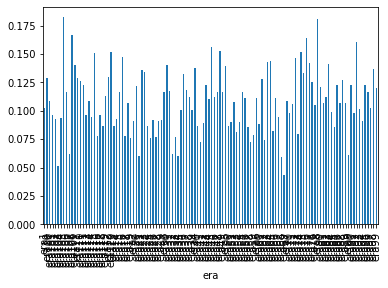

train_mean                   0.508099
train_std_dev                0.033352
train_less_than_half         0.382589
train_less_than_mean         0.570328
train_autocorrelation        0.111654
train_mean correlation       0.108587
train_Median Correlation     0.107894
train_Variance               0.000764
train_Std. Dev.              0.027643
train_sharpe                 3.928163
train_smart sharpe           3.500164
train_Numerai sharpe        12.302384
dtype: float64
False
predicting per-era scores...
(501808, 315)
Neutralizing...
Calculating Feature Exposure...
Drawdown...
evaluating on validation data...
predicting on validation...
getting per era scores
performance over time


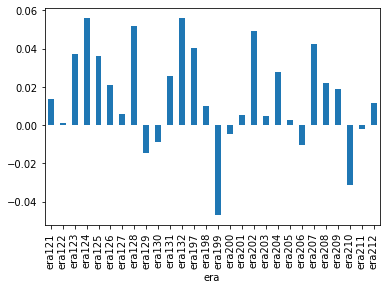

val_mean                  0.508844
val_std_dev               0.035887
val_less_than_half        0.374081
val_less_than_mean        0.576437
val_autocorrelation       0.178785
val_mean correlation      0.015033
val_Median Correlation    0.012606
val_Variance              0.000646
val_Std. Dev.             0.025409
val_sharpe                0.591648
val_smart sharpe          0.488159
val_Numerai sharpe        0.629570
dtype: float64
True
predicting per-era scores...
(137779, 314)
Neutralizing...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Calculating Feature Exposure...
Drawdown...

----model_XGB_1----
evaluating on training data...
predicting on train...
getting per era scores
performance over time


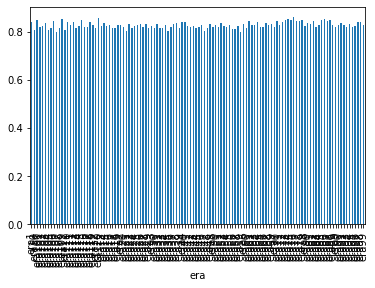

train_mean                    0.499993
train_std_dev                 0.058124
train_less_than_half          0.506363
train_less_than_mean          0.506279
train_autocorrelation         0.083096
train_mean correlation        0.828164
train_Median Correlation      0.827419
train_Variance                0.000165
train_Std. Dev.               0.012835
train_sharpe                 64.525860
train_smart sharpe           59.162733
train_Numerai sharpe        220.713051
dtype: float64
False
predicting per-era scores...
(501808, 315)
Neutralizing...
Calculating Feature Exposure...
Drawdown...
evaluating on validation data...
predicting on validation...
getting per era scores
performance over time


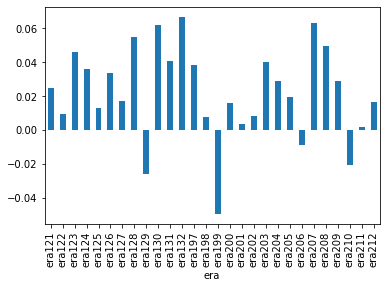

val_mean                  0.500735
val_std_dev               0.021915
val_less_than_half        0.506924
val_less_than_mean        0.522161
val_autocorrelation       0.030425
val_mean correlation      0.022210
val_Median Correlation    0.022159
val_Variance              0.000744
val_Std. Dev.             0.027271
val_sharpe                0.814405
val_smart sharpe          0.776602
val_Numerai sharpe        1.498192
dtype: float64
True
predicting per-era scores...
(137779, 314)
Neutralizing...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Calculating Feature Exposure...
Drawdown...

----model_XGB_2----
evaluating on training data...
predicting on train...
getting per era scores
performance over time


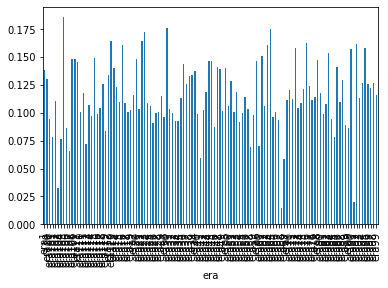

train_mean                   0.500026
train_std_dev                0.009448
train_less_than_half         0.513272
train_less_than_mean         0.514358
train_autocorrelation        0.024472
train_mean correlation       0.115336
train_Median Correlation     0.112094
train_Variance               0.000935
train_Std. Dev.              0.030579
train_sharpe                 3.771725
train_smart sharpe           3.665906
train_Numerai sharpe        11.885776
dtype: float64
False
predicting per-era scores...
(501808, 315)
Neutralizing...
Calculating Feature Exposure...
Drawdown...
evaluating on validation data...
predicting on validation...
getting per era scores
performance over time


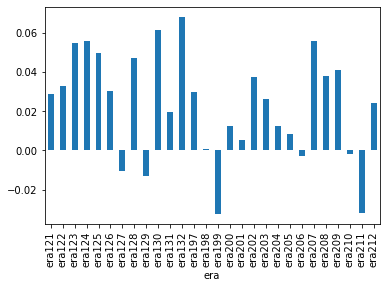

val_mean                  0.500283
val_std_dev               0.009405
val_less_than_half        0.506010
val_less_than_mean        0.518443
val_autocorrelation       0.107266
val_mean correlation      0.023087
val_Median Correlation    0.027484
val_Variance              0.000717
val_Std. Dev.             0.026780
val_sharpe                0.862094
val_smart sharpe          0.763101
val_Numerai sharpe        1.639132
dtype: float64
True
predicting per-era scores...
(137779, 314)
Neutralizing...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Calculating Feature Exposure...
Drawdown...

----model_XGB_3----
evaluating on training data...
predicting on train...
getting per era scores
performance over time


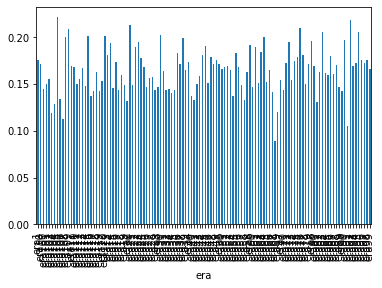

train_mean                   0.500014
train_std_dev                0.017414
train_less_than_half         0.505110
train_less_than_mean         0.505426
train_autocorrelation        0.030494
train_mean correlation       0.164551
train_Median Correlation     0.165038
train_Variance               0.000586
train_Std. Dev.              0.024210
train_sharpe                 6.796962
train_smart sharpe           6.566905
train_Numerai sharpe        22.055079
dtype: float64
False
predicting per-era scores...
(501808, 315)
Neutralizing...
Calculating Feature Exposure...
Drawdown...
evaluating on validation data...
predicting on validation...
getting per era scores
performance over time


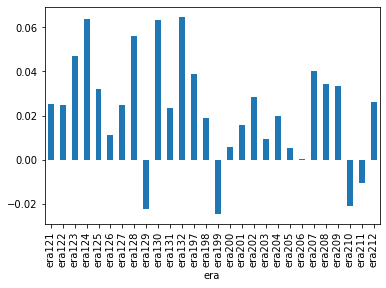

val_mean                  0.500524
val_std_dev               0.017449
val_less_than_half        0.499769
val_less_than_mean        0.512460
val_autocorrelation       0.059532
val_mean correlation      0.022732
val_Median Correlation    0.024955
val_Variance              0.000588
val_Std. Dev.             0.024246
val_sharpe                0.937566
val_smart sharpe          0.869257
val_Numerai sharpe        1.759794
dtype: float64
True
predicting per-era scores...
(137779, 314)
Neutralizing...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Calculating Feature Exposure...
Drawdown...

----model_XGB_4----
evaluating on training data...
predicting on train...
getting per era scores
performance over time


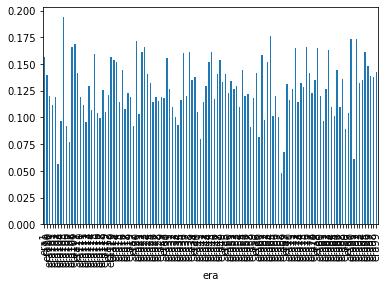

train_mean                   0.499961
train_std_dev                0.014593
train_less_than_half         0.505566
train_less_than_mean         0.504470
train_autocorrelation        0.009112
train_mean correlation       0.126647
train_Median Correlation     0.126006
train_Variance               0.000729
train_Std. Dev.              0.027009
train_sharpe                 4.689139
train_smart sharpe           4.627556
train_Numerai sharpe        14.907812
dtype: float64
False
predicting per-era scores...
(501808, 315)
Neutralizing...
Calculating Feature Exposure...
Drawdown...
evaluating on validation data...
predicting on validation...
getting per era scores
performance over time


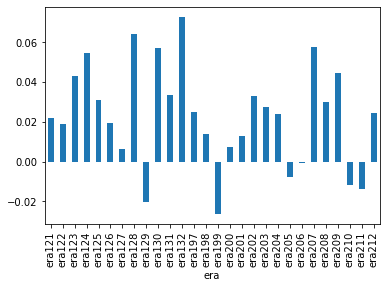

val_mean                  0.500405
val_std_dev               0.014519
val_less_than_half        0.497983
val_less_than_mean        0.509667
val_autocorrelation      -0.003256
val_mean correlation      0.022950
val_Median Correlation    0.024048
val_Variance              0.000641
val_Std. Dev.             0.025326
val_sharpe                0.906176
val_smart sharpe          0.892646
val_Numerai sharpe        1.714483
dtype: float64
True
predicting per-era scores...
(137779, 314)
Neutralizing...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Calculating Feature Exposure...
Drawdown...
CPU times: user 34min 13s, sys: 1min 31s, total: 35min 45s
Wall time: 28min 54s


In [23]:
%%time
all_model_metrics = dict()
for model_name in models:
    
    print(f"\n----{model_name}----")
    model_metrics = get_all_metrics(models[model_name], feature_names, fig_name = f"{model_name}.png")
    all_model_metrics[model_name] = model_metrics
    
    gc.collect()
    

In [24]:
metric_df = pd.DataFrame.from_dict(all_model_metrics)
metric_df

,keras_mlp_simple,model_XGB_1,model_XGB_2,model_XGB_3,model_XGB_4
train_mean,0.508099,0.499993,0.500026,0.500014,0.499961
train_std_dev,0.033352,0.058124,0.009448,0.017414,0.014593
train_less_than_half,0.382589,0.506363,0.513272,0.505110,0.505566
train_less_than_mean,0.570328,0.506279,0.514358,0.505426,0.504470
train_autocorrelation,0.111654,0.083096,0.024472,0.030494,0.009112
train_mean correlation,0.108587,0.828164,0.115336,0.164551,0.126647
train_Median Correlation,0.107894,0.827419,0.112094,0.165038,0.126006
train_Variance,0.000764,0.000165,0.000935,0.000586,0.000729
train_Std. Dev.,0.027643,0.012835,0.030579,0.024210,0.027009
train_sharpe,3.928163,64.525860,3.771725,6.796962,4.689139


In [25]:
metric_trans = metric_df.T
metric_trans["val_Numerai sharpe"] > 1

keras_mlp_simple    False
model_XGB_1          True
model_XGB_2          True
model_XGB_3          True
model_XGB_4          True
Name: val_Numerai sharpe, dtype: bool

In [26]:
training_data["id_seq"] = list(range(len(training_data)))
tournament_data["id_seq"] = list(range(len(tournament_data)))

In [ ]:
##############################################################################
######################## MAKE PREDICTIONS ####################################
##############################################################################

In [ ]:
model_XGBRegressor_2 = XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=50, colsample_bytree=0.5, nthread=15)
model_XGBRegressor_2.fit(training_data[feature_names], training_data[TARGET_NAME])

[11:25:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=50,
             n_jobs=1, nthread=15, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
%%time
print("Generating predictions on training data...")
training_preds = model_XGBRegressor_2.predict(training_data[feature_names])
training_data[PREDICTION_NAME] = training_preds

print("Generating predictions on tournament data...")
tournament_preds = model_XGBRegressor_2.predict(tournament_data[feature_names])
tournament_data[PREDICTION_NAME] = tournament_preds

Generating predictions on training data...
Generating predictions on tournament data...
CPU times: user 21.1 s, sys: 7.72 s, total: 28.8 s
Wall time: 21 s


In [ ]:
import numerapi
import torch
from torch.nn import Linear
from torch.nn import Sequential
from torch.functional import F

In [ ]:
def exposures(x, y):
    x = x - x.mean(dim=0)
    x = x / x.norm(dim=0)
    y = y - y.mean(dim=0)
    y = y / y.norm(dim=0)
    return torch.matmul(x.T, y)

def reduce_exposure(prediction, features, max_exp):
    # linear model of features that will be used to partially neutralize predictions
    lin = Linear(features.shape[1],  1, bias=False)
    lin.weight.data.fill_(0.)
    model = Sequential(lin)
    optimizer = torch.optim.Adamax(model.parameters(), lr=1e-4)
    feats = torch.tensor(np.float32(features)-.5)
    pred = torch.tensor(np.float32(prediction))
    start_exp = exposures(feats, pred[:,None])
    # set target exposure for each feature to be <= current exposure
    # if current exposure is less than max_exp, or <= max_exp if  
    # current exposure is > max_exp
    targ_exp = torch.clamp(start_exp, -max_exp, max_exp)

    for i in range(100000):
        optimizer.zero_grad()
        # calculate feature exposures of current linear neutralization
        exps = exposures(feats, pred[:,None]-model(feats))
        # loss is positive when any exposures exceed their target
        loss = (F.relu(F.relu(exps)-F.relu(targ_exp)) + F.relu(F.relu(-exps)-F.relu(-targ_exp))).sum()
        print(f'       loss: {loss:0.7f}', end='\r')
        if loss < 1e-7:
            neutralizer = [p.detach().numpy() for p in model.parameters()]
            neutralized_pred = pred[:,None]-model(feats)
            break
        loss.backward()
        optimizer.step()
    return neutralized_pred, neutralizer

def reduce_all_exposures(df, column, neutralizers=[],
                                     normalize=True,
                                     gaussianize=True,
                                     era_col="era",
                                     max_exp=0.1):
    unique_eras = df[era_col].unique()
    computed = []
    for u in unique_eras:
        print(u, '\r')
        df_era = df[df[era_col] == u]
        scores = df_era[column].values
        exposure_values = df_era[neutralizers].values
        
        if normalize:
            scores2 = []
            for x in scores.T:
                x = (scipy.stats.rankdata(x, method='ordinal') - .5) / len(x)
                if gaussianize:
                    x = scipy.stats.norm.ppf(x)
                scores2.append(x)
            scores = np.array(scores2)[0]

        scores, neut = reduce_exposure(scores, exposure_values, max_exp)

        scores /= scores.std()

        computed.append(scores.detach().numpy())

    return pd.DataFrame(np.concatenate(computed), columns=column, index=df.index)

In [ ]:
tournament_data[PREDICTION_NAME]

In [ ]:
data_rfe_10 = reduce_all_exposures(tournament_data,
                                   [PREDICTION_NAME],
                                   neutralizers=feature_names,
                                   era_col="era",
                                   max_exp=0.10)

In [ ]:
# replace prediction with reduced feature exposure prediction and rescale to [0,1]
tournament_data[PREDICTION_NAME] = data_rfe_10[PREDICTION_NAME]
tournament_data[PREDICTION_NAME] -= tournament_data[PREDICTION_NAME].min()
tournament_data[PREDICTION_NAME] /= tournament_data[PREDICTION_NAME].max()

In [ ]:
tournament_data[PREDICTION_NAME]

In [ ]:
##############################################################################
######################### MAKE SUBMISSION #################################### 
##############################################################################

In [ ]:
tournament_data[PREDICTION_NAME].to_csv(f"{TOURNAMENT_NAME}_{current_ds}_submission.csv")

In [ ]:
# NameOfYourAI
public_id = "7TISUDGAWEVO2B35ECOQQXU2RWXGZN3I"
secret_key = "QJYUWIMFEEDNZ4GHUO6VSSKPMRCBFJIMJ7BZ65ESIWRN4YHGYHSRJDNL64TAG7EH"
model_id = "d49c26a4-aa5b-4490-9d58-300c5e05d996"
napi = numerapi.NumerAPI(public_id=public_id, secret_key=secret_key)

In [ ]:
print("Uploading DataFrame in Numerai...")
submission_id = napi.upload_predictions(f"{TOURNAMENT_NAME}_{current_ds}_submission.csv", model_id=model_id)
print("DataFrame Uploaded...")

2020-12-06 12:23:40,372 INFO numerapi.base_api: uploading predictions...


Uploading DataFrame in Numerai...
DataFrame Uploaded...


In [ ]:
##############################################################################
########################  SAVE AND LOAD THE MODEL  ###########################
##############################################################################

In [ ]:
# SAVE MODEL
model.save_weights('numeraiThe_Model.h5', overwrite=True, save_format=None, options=None)

In [ ]:
# LOAD MODEL
model.load_weights('numeraiThe_Model.h5', by_name=False, skip_mismatch=False, options=None)